<h1 align="center">Quantum Squared-Distance Classifier </h1> 
<div align="center"> This code is based on the work done in https://github.com/Brotherhood94/quantum_distance_based_classifier </div>


# Install qiskit

In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.8 MB/s 
     |████████████████████████████████| 19.2 MB 1.2 MB/s 
     |████████████████████████████████| 240 kB 41.9 MB/s 
     |████████████████████████████████| 106 kB 49.1 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 943 kB 67.6 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 4.0 MB 41.5 MB/s 
     |████████████████████████████████| 1.9 MB 43.8 MB/s 
     |████████████████████████████████| 112 kB 71.5 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.0-py3-none-any.whl size=12188 sha256=2eaf08e55fe14a07ada156641d48ecccf6ca20ef0e3733515b5fe2bead4a258d
  Stored in directory: /root/.cache/pip/wheels/63/d0/9a/25714

# Import Packages

In [7]:
import qiskit
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, Aer
from qiskit.extensions import Initialize, UnitaryGate
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city
#from qiskit_textbook.tools import random_state, array_to_latex


# Define Model

This code is closely followed the original [paper](https://arxiv.org/pdf/1703.10793.pdf) rather than the simplified version in my blog. 

So, you can try to check out the paper if you want to fully understand the code. But, I recommend you first look at the way we implement a quantum algorithm in Python rather than going to details of the design.

In [9]:

class QDistanceBasedClassifier:
    
####################################################################
    def get_circuit(self):
        return self.qc
        
####################################################################
        
    def _step_A(self, a):
        '''Uniform superposition of ancilla and index qubit'''
        self.qc.h(a)
        self.qc.barrier()

####################################################################

    def _step_B(self, alpha, a, b, c):
        '''Loading test vector  '''
        self.qc.mcry(alpha, a, c[0], None) 
        self.qc.barrier()
        self.qc.x(a)
        self.qc.barrier()
        self.qc.h(b)
        self.qc.barrier()

        
####################################################################

    def _step_C(self, a, b, c):
        '''Loading first training vector'''
        self.qc.ccx(a,b,c)
        self.qc.x(b)
        self.qc.barrier()

####################################################################
        
    def _step_D(self, alpha, a, b, c, d):
        '''Load second training vector'''
        self.qc.mcry(alpha, a[0:]+b[0:], c[0], None) 
        self.qc.barrier()
        self.qc.cx(b, d)
        self.qc.barrier()
        
####################################################################

    def _step_F(self, a):
        '''Compute distance'''
        self.qc.h(a)
        self.qc.barrier()
        
####################################################################

    def step_measure(self):
        '''Measurements'''
        self.qc.measure(self.aqr, self.c_areg)
        self.qc.measure(self.cqr, self.c_creg)
        
####################################################################

    def _init_qc(self):
        aqr = QuantumRegister(1, name="ancilla ")
        mqr = QuantumRegister(1, name="index qregister ") 
        iqr = QuantumRegister(1, name="data register ")
        cqr = QuantumRegister(1, name="classes ")

        c_areg = ClassicalRegister(1, name="classical ancilla ")
        c_creg = ClassicalRegister(1, name="classical classes ")
        
        qc = QuantumCircuit(aqr, mqr, iqr, cqr, c_areg, c_creg)
        return qc, aqr, mqr, iqr, cqr, c_areg, c_creg
    
####################################################################

    def __init__(self, alpha_tr_1, alpha_test):
        self.qc, self.aqr, self.mqr, self.iqr, self.cqr, self.c_areg, self.c_creg = self._init_qc()
        
        #Uniform superpos of ancilla and index qubits
        self._step_A(self.aqr)

        #Loading test vector
        self._step_B(alpha_test, self.aqr, self.mqr, self.iqr)

        #Loading first training vector
        self._step_C(self.aqr, self.mqr, self.iqr)

        #Load second training vector
        self._step_D(alpha_tr_1, self.aqr, self.mqr, self.iqr, self.cqr)

        #compute distance
        self._step_F(self.aqr)
        
        self.step_measure() 

# Drawing Tool

In [11]:
import matplotlib

def draw_axes():
    # dummy points for zooming out
    points = [ [1.3,0], [0,1.3], [-1.3,0], [0,-1.3] ]
    # coordinates for the axes
    arrows = [ [1.1,0], [0,1.1], [-1.1,0], [0,-1.1] ]

    # drawing dummy points
    for p in points: matplotlib.pyplot.plot(p[0],p[1]+0.2)
    # drawing the axes
    for a in arrows: matplotlib.pyplot.arrow(0,0,a[0],a[1],head_width=0.04, head_length=0.08)

def draw_unit_circle():
    unit_circle= matplotlib.pyplot.Circle((0,0),1,color='black',fill=False)
    matplotlib.pyplot.gca().add_patch(unit_circle)

def draw_datapoint(x,y, name, marker='o',color='blue'):
    matplotlib.pyplot.plot(x,y, marker=marker, markersize=7, color=color)
    x2 = 1.15 * x
    y2 = 1.15 * y
    #matplotlib.pyplot.text(x2,y2,name)

def draw_quantum_state(x,y,name, color='blue'):
    # shorten the line length to 0.92
    # line_length + head_length should be 1
    x1 = 0.92 * x
    y1 = 0.92 * y
    matplotlib.pyplot.arrow(0,0,x1,y1,head_width=0.04,head_length=0.08,color=color)
    x2 = 1.15 * x
    y2 = 1.15 * y
    matplotlib.pyplot.text(x2,y2,name)

def draw_qubit():
    # draw a figure
    matplotlib.pyplot.figure(figsize=(6,6), dpi=60)
    # draw the origin
    matplotlib.pyplot.plot(0,0,'ro') # a point in red color
    # drawing the axes by using one of our predefined functions
    draw_axes()
    # drawing the unit circle by using one of our predefined functions
    draw_unit_circle()
    # drawing |0>
    matplotlib.pyplot.plot(1,0,"o")
    matplotlib.pyplot.text(1.05,0.05,"|0>")
    # drawing |1>
    matplotlib.pyplot.plot(0,1,"o")
    matplotlib.pyplot.text(0.05,1.05,"|1>")
    # drawing -|0>
    matplotlib.pyplot.plot(-1,0,"o")
    matplotlib.pyplot.text(-1.2,-0.1,"-|0>")
    # drawing -|1>
    matplotlib.pyplot.plot(0,-1,"o")
    matplotlib.pyplot.text(-0.2,-1.1,"-|1>")

# Test

In [10]:
test_1 = [0.866, 0.500]   
tr_0 = [0.141,0.990] 
tr_1 = [0.921, 0.390]


#Computing the rotation angle
alpha_test = np.arctan2(test_1[1], test_1[0])*2
alpha_tr_1 = np.arctan2(tr_1[1], tr_1[0])*2
print("Test Vector's alpha:", alpha_test)
print("Training_1 Vector's alpha:", alpha_tr_1)
#using arcatan2 --> Obtain the correct quadrans. Otherwise, with arctan(y/x) you cannot get the correct quadrant
#ex: -1.52 can be obtained from (-y/x) and (y/-x)


q_distance_based_classifier = QDistanceBasedClassifier(alpha_tr_1, alpha_test)

Test Vector's alpha: 1.0472229555399388
Training_1 Vector's alpha: 0.801118798109258


In [13]:
q_distance_based_circuit = q_distance_based_classifier.get_circuit()
q_distance_based_circuit.draw()

┌───┐ ░                                           ░ ┌───┐»
          ancilla : ┤ H ├─░──────────────────■────────────────────■───░─┤ X ├»
                    └───┘ ░                  │                    │   ░ └───┘»
  index qregister : ──────░──────────────────┼────────────────────┼───░──────»
                          ░ ┌─────────────┐┌─┴─┐┌──────────────┐┌─┴─┐ ░      »
    data register : ──────░─┤ Ry(0.52361) ├┤ X ├┤ Ry(-0.52361) ├┤ X ├─░──────»
                          ░ └─────────────┘└───┘└──────────────┘└───┘ ░      »
          classes : ──────░───────────────────────────────────────────░──────»
                          ░                                           ░      »
classical ancilla : ═════════════════════════════════════════════════════════»
                                                                             »
classical classes : ═════════════════════════════════════════════════════════»
                                                                             »
«                     ░       ░            ░                     »
«          ancilla : ─░───────░───■────────░──────────────────■──»
«                     ░ ┌───┐ ░   │  ┌───┐ ░                  │  »
«  index qregister : ─░─┤ H ├─░───■──┤ X ├─░──────────────────■──»
«                     ░ └───┘ ░ ┌─┴─┐└───┘ ░ ┌─────────────┐┌─┴─┐»
«    data register : ─░───────░─┤ X ├──────░─┤ Ry(0.40056) ├┤ X ├»
«                     ░       ░ └───┘      ░ └─────────────┘└───┘»
«          classes : ─░───────░────────────░─────────────────────»
«                     ░       ░            ░                     »
«classical ancilla : ════════════════════════════════════════════»
«                                                                »
«classical classes : ════════════════════════════════════════════»
«                                                                »
«                                          ░       ░ ┌───┐ ░ ┌─┐   
«          ancilla : ──────────────────■───░───────░─┤ H ├─░─┤M├───
«                                      │   ░       ░ └───┘ ░ └╥┘   
«  index qregister : ──────────────────■───░───■───░───────░──╫────
«                    ┌──────────────┐┌─┴─┐ ░   │   ░       ░  ║    
«    data register : ┤ Ry(-0.40056) ├┤ X ├─░───┼───░───────░──╫────
«                    └──────────────┘└───┘ ░ ┌─┴─┐ ░       ░  ║ ┌─┐
«          classes : ──────────────────────░─┤ X ├─░───────░──╫─┤M├
«                                          ░ └───┘ ░       ░  ║ └╥┘
«classical ancilla : ═════════════════════════════════════════╩══╬═
«                                                                ║ 
«classical classes : ════════════════════════════════════════════╩═
«

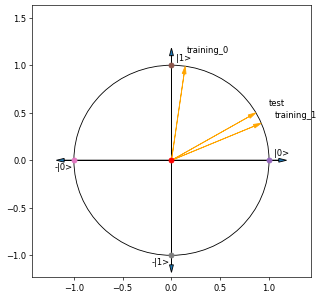

In [15]:
draw_qubit()
draw_quantum_state(test_1[0],test_1[1],"test", color='orange')
draw_quantum_state(tr_1[0],tr_1[1],"training_1", color='orange')
draw_quantum_state(tr_0[0],tr_0[1],"training_0", color='orange')

This code allows you to run your quantum circuit on a simulator

In [19]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(q_distance_based_circuit, simulator, shots=10000)
result = job.result()
counts = result.get_counts(q_distance_based_circuit)
counts = {k: counts[k] for k in counts.keys() & {'0 0', '1 0'}}

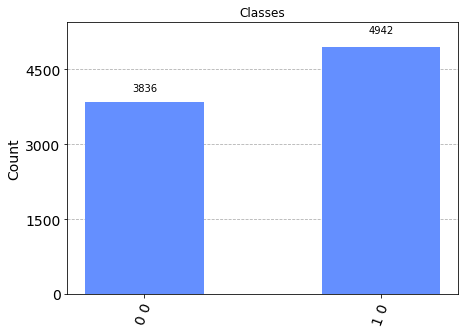

In [20]:
plot_histogram(counts, title="Classes")

You can see that p(0) = 3836/10000 = 0.38 and p(1) = 0.49

Therefore the Passanger 3 should assign to label 1. 